In [3]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


# 生成标签值：下一天收盘价（涉及删除最后一条数据，不要重复执行该函数）
def generate_label(data_path):
    df = pd.read_csv(data_path)
    next_close = list()
    for i in range(len(df['close']) - 1):
        next_close.append(df['close'][i + 1])
    next_close.append(0)
    df['next_close'] = next_close
    df.drop(df.index[-1], inplace=True)
    df.to_csv('temp.csv', index=None)


# 生成训练和测试数据
def generate_model_data(data_path, alpha, seq_len):
    df = pd.read_csv(data_path)
    train_day = int((len(df['close']) - seq_len + 1))
    for property in ['open', 'close', 'high', 'low', 'volume', 'next_close']:
        df[property] = scaler.fit_transform(np.reshape(np.array(df[property]), (-1, 1)))
    X_data, Y_data = list(), list()
    # 生成时序数据
    for i in range(train_day):
        Y_data.append(df['next_close'][i + seq_len - 1])
        for j in range(seq_len):
            for m in ['open', 'close', 'high', 'low', 'volume']:
                X_data.append(df[m][i + j])
    X_data = np.reshape(np.array(X_data), (-1, 5 * seq_len))  # 5表示特征数量*天数
    train_length = int(len(Y_data) * alpha)
    X_train = np.reshape(np.array(X_data[:train_length]), (len(X_data[:train_length]), seq_len, 5))
    X_test = np.reshape(np.array(X_data[train_length:]), (len(X_data[train_length:]), seq_len, 5))
    Y_train, Y_test = np.array(Y_data[:train_length]), np.array(Y_data[train_length:])
    return X_train, Y_train, X_test, Y_test,X_data


def calc_MAPE(real, predict):
    Score_MAPE = 0
    for i in range(len(predict[:, 0])):
        Score_MAPE += abs((predict[:, 0][i] - real[:, 0][i]) / real[:, 0][i])
    Score_MAPE = Score_MAPE * 100 / len(predict[:, 0])
    return Score_MAPE


def calc_AMAPE(real, predict):
    Score_AMAPE = 0
    Score_MAPE_DIV = sum(real[:, 0]) / len(real[:, 0])
    for i in range(len(predict[:, 0])):
        Score_AMAPE += abs((predict[:, 0][i] - real[:, 0][i]) / Score_MAPE_DIV)
    Score_AMAPE = Score_AMAPE * 100 / len(predict[:, 0])
    return Score_AMAPE


def evaluate(real, predict):
    RMSE = math.sqrt(mean_squared_error(real[:, 0], predict[:, 0]))
    MAE = mean_absolute_error(real[:, 0], predict[:, 0])
    MAPE = calc_MAPE(real, predict)
    AMAPE = calc_AMAPE(real, predict)
    return RMSE, MAE, MAPE, AMAPE


def lstm_model(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1, activation='hard_sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=200, batch_size=20, verbose=1)

    trainPredict = model.predict(X_train)
    trainPredict = scaler.inverse_transform(trainPredict)
    Y_train = scaler.inverse_transform(np.reshape(Y_train, (-1, 1)))

    testPredict = model.predict(X_test)
    testPredict = scaler.inverse_transform(testPredict)
    Y_test = scaler.inverse_transform(np.reshape(Y_test, (-1, 1)))

    return Y_train, trainPredict, Y_test, testPredict


if __name__ == '__main__':
    data_path = 'stock.csv'
    seq_len = 15
    alpha = 0.8
    #generate_label(data_path)
    scaler = MinMaxScaler(feature_range=(0, 1))
    #scaler = StandardScaler()
    X_train, Y_train, X_test, Y_test,X_data = generate_model_data('temp.csv', alpha, seq_len)
    train_Y, trainPredict, test_Y, testPredict = lstm_model(X_train, Y_train, X_test, Y_test)





Epoch 1/200
28/28 [==============================] - 2s 7ms/step - loss: 0.0303
Epoch 2/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 3/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 4/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 5/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 6/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 7/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 8/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 9/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 10/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 11/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 12/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 13/200
28/28 [=================

28/28 [==============================] - 0s 7ms/step - loss: 5.5470e-04
Epoch 100/200
28/28 [==============================] - 0s 7ms/step - loss: 5.4487e-04
Epoch 101/200
28/28 [==============================] - 0s 7ms/step - loss: 5.3476e-04
Epoch 102/200
28/28 [==============================] - 0s 7ms/step - loss: 5.1928e-04
Epoch 103/200
28/28 [==============================] - 0s 7ms/step - loss: 5.2992e-04
Epoch 104/200
28/28 [==============================] - 0s 7ms/step - loss: 5.6219e-04
Epoch 105/200
28/28 [==============================] - 0s 7ms/step - loss: 5.5095e-04
Epoch 106/200
28/28 [==============================] - 0s 7ms/step - loss: 5.9283e-04
Epoch 107/200
28/28 [==============================] - 0s 7ms/step - loss: 6.0661e-04
Epoch 108/200
28/28 [==============================] - 0s 7ms/step - loss: 5.2583e-04
Epoch 109/200
28/28 [==============================] - 0s 7ms/step - loss: 5.3110e-04
Epoch 110/200
28/28 [==============================] - 0s 7ms/step -

28/28 [==============================] - 0s 7ms/step - loss: 4.2459e-04
Epoch 195/200
28/28 [==============================] - 0s 7ms/step - loss: 4.3296e-04
Epoch 196/200
28/28 [==============================] - 0s 7ms/step - loss: 4.2796e-04
Epoch 197/200
28/28 [==============================] - 0s 7ms/step - loss: 4.6574e-04
Epoch 198/200
28/28 [==============================] - 0s 7ms/step - loss: 4.4522e-04
Epoch 199/200
28/28 [==============================] - 0s 7ms/step - loss: 4.3686e-04
Epoch 200/200
28/28 [==============================] - 0s 7ms/step - loss: 4.3613e-04


array([[[0.13141614, 0.11652187, 0.10498336, 0.14940403, 0.41455648],
        [0.1104694 , 0.11512014, 0.08616507, 0.13815772, 0.22170937],
        [0.1343337 , 0.15961175, 0.12869413, 0.16344721, 0.50064541],
        ...,
        [0.15095716, 0.15033522, 0.13053223, 0.17145228, 0.45649694],
        [0.14508889, 0.1522064 , 0.11573862, 0.11803069, 0.47613214],
        [0.10912997, 0.12856217, 0.09091406, 0.12998928, 0.34725245]],

       [[0.1104694 , 0.11512014, 0.08616507, 0.13815772, 0.22170937],
        [0.1343337 , 0.15961175, 0.12869413, 0.16344721, 0.50064541],
        [0.15639443, 0.14009997, 0.1225512 , 0.15697781, 0.35298189],
        ...,
        [0.14508889, 0.1522064 , 0.11573862, 0.11803069, 0.47613214],
        [0.10912997, 0.12856217, 0.09091406, 0.12998928, 0.34725245],
        [0.11595308, 0.08971053, 0.09176136, 0.12512743, 0.16309152]],

       [[0.1343337 , 0.15961175, 0.12869413, 0.16344721, 0.50064541],
        [0.15639443, 0.14009997, 0.1225512 , 0.15697781, 0.3

In [4]:
    RMSE, MAE, MAPE, AMAPE = evaluate(test_Y, testPredict)
    print(RMSE, MAE, MAPE, AMAPE)


101.49823301309272 78.49980489979622 2.374533921172568 2.366686349305


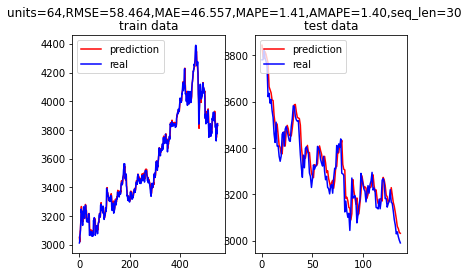

In [4]:
    plt.subplot(121)
    plt.plot(list(trainPredict), color='red', label='prediction')
    plt.plot(list(train_Y), color='blue', label='real')
    plt.legend(loc='upper left')
    plt.title('train data')

    plt.subplot(122)
    plt.plot(list(testPredict), color='red', label='prediction')
    plt.plot(list(test_Y), color='blue', label='real')
    plt.legend(loc='upper left')
    plt.title('test data')
    plt.suptitle('units=64,RMSE=58.464,MAE=46.557,MAPE=1.41,AMAPE=1.40,seq_len=30')
    plt.show()

In [30]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((537, 30, 5), (537,), (135, 30, 5), (135,))

In [33]:
    df = pd.read_csv('UAV.csv')    
    
    for i in ['xa','ya','za','row','pitch','yaw']:
        next_close = list()
        for j in range(len(df[i])-1):
            next_close.append(df[i][j+1])
        next_close.append(0)
        df['new'+i] = next_close
    df.to_csv('new_UVA.csv',index=None)

In [11]:
X_test.shape

(138, 15, 5)

NameError: name 'test_X' is not defined